# U-SimBA Demo
This notebook explains the usage of U-SimBA using a simple NN model for MNIST image classification.

## Setup
Install U-SimBA, implemented using Adversarial Robustness Toolbox (ART; version 1.7.0). Code is available in [our forked version of ART](https://github.com/kztakemoto/adversarial-robustness-toolbox/blob/main/art/attacks/evasion/universal_simba.py).

In [ ]:
!pip install git+https://github.com/kztakemoto/adversarial-robustness-toolbox

Import libraries.

In [25]:
import tensorflow as tf
import numpy as np
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import Universal_SimBA
import matplotlib.pyplot as plt
import logging
import random

Configure a logger to capture ART outputs; these are printed in console and the level of detail is set to INFO.

In [26]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('[%(levelname)s] %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

### MNIST model

Load MNIST dataset.

In [27]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))
X_train, X_test = X_train / 255.0, X_test / 255.0

Generate an input dataset, used to generate a UAP, and validation dataset from the test dataset.

In [28]:
# Input dataset consists of randomly selected 100 images per class.
np.random.seed(111)
input_idx = []
num_each_class = 100
for class_i in range(10):
    idx = np.random.choice(np.where(y_test == class_i)[0], num_each_class, replace=False).tolist()
    input_idx = input_idx + idx
random.shuffle(input_idx)
X_input, y_input = X_test[input_idx], y_test[input_idx]

# The rest is used as the validation data
rest_idx = np.ones(len(X_test), dtype=bool)
rest_idx[input_idx] = False
X_val, y_val = X_test[rest_idx], y_test[rest_idx]

Define and train the NN model.

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2924 - accuracy: 0.9150
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1389 - accuracy: 0.9581
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1038 - accuracy: 0.9682
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0846 - accuracy: 0.9739
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0716 - accuracy: 0.9776


Wrap the model to be able to use it in ART.

In [30]:
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
)

Define the functions for visualization.

In [42]:
# set MNIST labels
label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# normalization for image plot
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-5)

# plot sample images
def img_plot(x, X_adv, target=None):
    preds_X_adv = np.argmax(classifier.predict(X_adv), axis=1)
    preds_x = np.argmax(classifier.predict(x), axis=1)
    if target is None:
        sr = np.sum(preds_X_adv != preds_x) / x.shape[0]
        print('Success rate of non-targeted attacks: {:.1f}%'.format(sr * 100))
    else:
        sr = np.sum(preds_X_adv == np.argmax(target, axis=1)) / x.shape[0]
        print('Success rate of targeted attacks: {:.1f}%'.format(sr * 100))
  
    print('Plot the clean images (top), adversarial images (bottom), and UAP')

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n + 1):
        x_ori = norm(x[i-1].reshape(28,28))
        x_adv = norm(X_adv[i-1].reshape(28,28))
        noise = norm((X_adv[i-1] - x[i-1]).reshape(28,28))

        # display original
        if i != 0:
            ax = plt.subplot(2, n + 1, i + 1)
            plt.title(label[preds_x[i-1]])
            plt.imshow(x_ori)
            plt.gray()
            ax.set_axis_off()

        # display original + noise
        bx = plt.subplot(2, n + 1, i + n + 2)
        if i == 0:
            plt.title('UAP')
            plt.imshow(noise)
            plt.gray()
        else:
            plt.title(label[preds_X_adv[i-1]])
            plt.imshow(x_adv)
            plt.gray()
        bx.set_axis_off()

    plt.show()

## Nontargeted attacks

Build attacker.

In [32]:
nontargeted_attack = Universal_SimBA(
                classifier,
                attack='dct',
                epsilon=0.2,
                freq_dim=int(X_input.shape[1]/8), # this is related to $f_d$ in our paper; specifically, freq_dim = 1 / $f_d$
                max_iter=2000, # corresponds to $i_\max$ in our paper
                eps=0.2, # corresponds to $\xi$ in our paper
                norm=np.inf, # corresponds to $p$ in our paper
                targeted=False,
                batch_size=256
            )

Perform nontargeted attacks and get adversarial examples for the input data.

In [33]:
X_input_adv_nontargeted = nontargeted_attack.generate(X_input)

[INFO] Using the model predictions as the correct labels for SimBA.
[INFO] Using the model predictions as the correct labels for SimBA.
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 10 iterations: 1.60% (Linf norm of noise: 0.05)
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 10 iterations: 1.60% (Linf norm of noise: 0.05)
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 20 iterations: 3.80% (Linf norm of noise: 0.08)
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 20 iterations: 3.80% (Linf norm of noise: 0.08)
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 30 iterations: 6.50% (Linf norm of noise: 0.10)
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 30 iterations: 6.50% (Linf norm of noise: 0.10)
[INFO] Success rate of Universal SimBA (dct) non-targeted attack at 40 iterations: 11.00% (Linf norm of noise: 0.12)
[INFO] Success rate of Universal SimBA (dct) non-ta

Generate adversarial examples for the validation data.

In [34]:
X_val_adv_nontargeted = X_val + nontargeted_attack.noise

Comput success rate of non-targeted attacks (fooling rate $R_f$) for the validation dataset and plot the clean images, UAP, and adversarial images.



Success rate of non-targeted attacks: 86.4%
Plot the clean images (top), adversarial images (bottom), and UAP


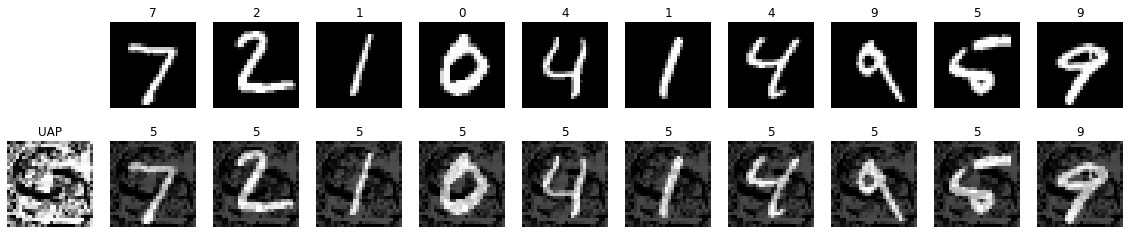

In [43]:
img_plot(X_val, X_val_adv_nontargeted)

### Supplementary note
The above example considers DCT basis as search directions.

Standard basis (i.e., pixel attack) is also used.

In [ ]:
nontargeted_attack = Universal_SimBA(
                classifier,
                attack='px',
                epsilon=0.2,
                max_iter=2000,
                eps=0.2,
                norm=np.inf,
                targeted=False,
                batch_size=256
            )

## Targeted attacks

Get one-hot verctors for a target class.

In [50]:
target_class = 2
target_X_input = tf.keras.utils.to_categorical([target_class] * len(X_input), 10)
target_X_val = tf.keras.utils.to_categorical([target_class] * len(X_val), 10)

Build attacker.

In [51]:
targeted_attack = Universal_SimBA(
                classifier,
                attack='dct',
                epsilon=0.2,
                freq_dim=int(X_input.shape[1]/8),
                max_iter=2000,
                eps=0.2,
                norm=np.inf,
                targeted=True,
                batch_size=256
            )

Perform targeted attacks and get adversarial examples for the input data.

In [52]:
X_input_adv_targeted = targeted_attack.generate(X_input, y = target_X_input)

[INFO] Success rate of Universal SimBA (dct) targeted attack at 10 iterations: 10.40% (Linf norm of noise: 0.08)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 10 iterations: 10.40% (Linf norm of noise: 0.08)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 20 iterations: 11.30% (Linf norm of noise: 0.12)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 20 iterations: 11.30% (Linf norm of noise: 0.12)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 30 iterations: 13.40% (Linf norm of noise: 0.16)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 30 iterations: 13.40% (Linf norm of noise: 0.16)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 40 iterations: 15.10% (Linf norm of noise: 0.16)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 40 iterations: 15.10% (Linf norm of noise: 0.16)
[INFO] Success rate of Universal SimBA (dct) targeted attack at 50 iterations: 17.50% (Linf norm

Generate adversarial examples for the validation data.

In [53]:
X_val_adv_targeted = X_val + targeted_attack.noise

Comput success rate of targeted attacks (target attack success rate $R_s$) for the validation dataset and plot the clean images, UAP, and adversarial images.

Success rate of targeted attacks: 93.2%
Plot the clean images (top), adversarial images (bottom), and UAP


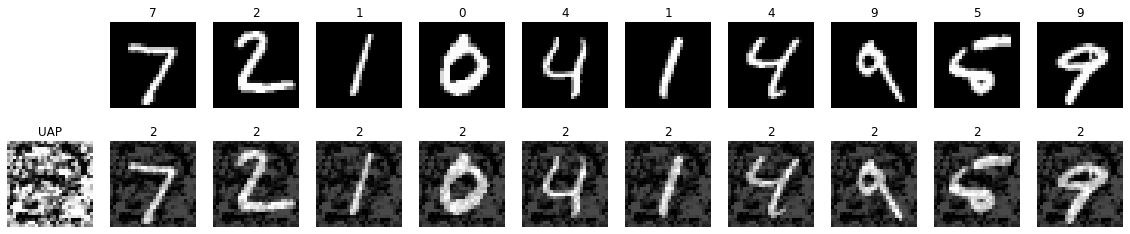

In [54]:
img_plot(X_val, X_val_adv_targeted, target_X_val)